In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import datetime as dt
import yfinance as yf

import talib
import mplfinance as mpf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm

Загружаем исходные данные

In [2]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = dt.datetime.now().strftime('%Y-%m-%d')

data = yf.download('AAPL', TRAIN_START_DATE, TEST_END_DATE)
data.to_csv('data/AAPL.csv')


[*********************100%%**********************]  1 of 1 completed


In [3]:
# data = pd.read_csv('data/AAPL.csv')

In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.740172,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.855819,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.808715,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.748023,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.799052,673500800


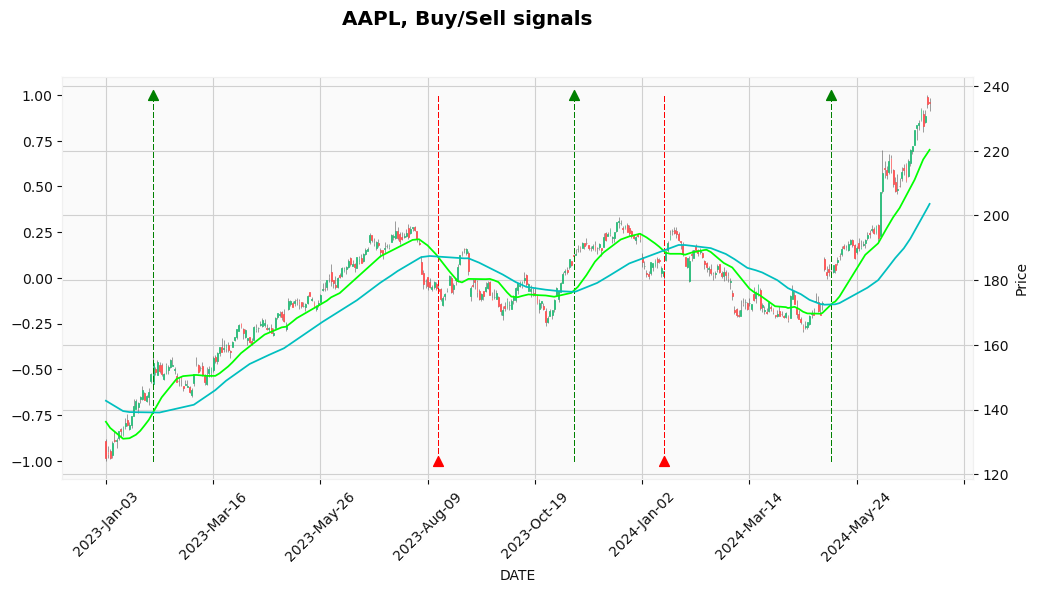

In [5]:
start_date = dt.datetime(2023, 1, 1)
finish_date = dt.datetime.now()

# make mva 20/50 days
mav20 = data['Close'].rolling(window=20).mean()
mav20 = mav20[mav20.index > start_date]
mav20 = mav20[mav20.index < finish_date]
mav50 = data['Close'].rolling(window=50).mean()
mav50 = mav50[mav50.index > start_date]
mav50 = mav50[mav50.index < finish_date]

# make trade signals
signal = mav20 > mav50
diff_plus = signal - signal.shift()
diff_plus[diff_plus<=0] = np.nan
diff_minus = signal - signal.shift()
diff_minus[diff_minus>=0] = np.nan

# make additional plots
apds = [mpf.make_addplot(mav20,color='lime'),
        mpf.make_addplot(mav50,color='c'), 
        mpf.make_addplot(diff_plus, type='scatter', markersize=50, marker='^', color='green'),
        mpf.make_addplot(diff_minus, type='scatter', markersize=50, marker='^', color='red'),
]

# crop data
data1 = data.loc[(data.index > start_date) & (data.index < finish_date)]

# color array for trade signals
colors_ar = []
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date])):
        colors_ar.append('green')
for i in range(len([date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date])):
        colors_ar.append('red')


# make figure
fig, axs = mpf.plot(data1,
	#  mav=(20, 50),
	addplot=apds,
	#  volume=True,
	style='yahoo',
	type='candle',
	figratio=(22,10),
	title='AAPL, Buy/Sell signals',
	ylabel='Price',
	returnfig=True,
	vlines=dict(vlines=[date_obj.strftime('%Y-%m-%d') for date_obj in diff_plus[~diff_plus.isna()].index.date] + [date_obj.strftime('%Y-%m-%d') for date_obj in diff_minus[~diff_minus.isna()].index.date],
				linewidths=(1), 
				colors=colors_ar, 
				linestyle='--'),
	#  savefig='../Presentation/img/buy_sell_signal.png',
	xlabel='DATE')

## Тестирвоание стратегии

In [6]:
class SmaCross(Strategy):
    n1 = 20
    n2 = 50

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(data.loc[data.index.year > 2022], SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
# bt.plot();

print(f'Equity Final: \t$ {np.round(output["Equity Final [$]"], 2):,}')
print(f'Profit \t\t$: {np.round(output["Equity Final [$]"] - 10000, 2):,}')

Equity Final: 	$ 12,086.3
Profit 		$: 2,086.3


In [9]:
output

Start                     2023-01-03 00:00:00
End                       2024-07-16 00:00:00
Duration                    560 days 00:00:00
Exposure Time [%]                   59.480519
Equity Final [$]                  12086.30229
Equity Peak [$]                   12086.30229
Return [%]                          20.863023
Buy & Hold Return [%]               87.750866
Return (Ann.) [%]                    13.20479
Volatility (Ann.) [%]               18.757296
Sharpe Ratio                         0.703982
Sortino Ratio                        1.259712
Calmar Ratio                         0.800005
Max. Drawdown [%]                  -16.505878
Avg. Drawdown [%]                   -5.602427
Max. Drawdown Duration      229 days 00:00:00
Avg. Drawdown Duration       46 days 00:00:00
# Trades                                    4
Win Rate [%]                             50.0
Best Trade [%]                      28.467869
Worst Trade [%]                     -6.258586
Avg. Trade [%]                    

In [10]:
output["Equity Final [$]"]

12086.302290283202

## Нейросетевая модель

Индикаторы тех анализа

In [7]:
# SMA
data["sma_5"] = talib.SMA(data["Close"], timeperiod=5)
data["sma_10"] = talib.SMA(data["Close"], timeperiod=10)
data["sma_15"] = talib.SMA(data["Close"], timeperiod=15)
data["sma_20"] = talib.SMA(data["Close"], timeperiod=20)
data["sma_50"] = talib.SMA(data["Close"], timeperiod=50)
data["sma_200"] = talib.SMA(data["Close"], timeperiod=200)
data["sma_ratio_5_15"] = data['sma_15'] / data['sma_5']
data["sma_ratio_10_50"] = data['sma_50'] / data['sma_15']
data['sma_5_Volume'] = talib.SMA(data["Volume"], timeperiod=5)
data['sma_10_Volume'] = talib.SMA(data["Volume"], timeperiod=10)
data['sma_15_Volume'] = talib.SMA(data["Volume"], timeperiod=15)
data['sma_50_Volume'] = talib.SMA(data["Volume"], timeperiod=50)
data["sma_Volume_ratio_5_15"] = data['sma_5_Volume'] / data['sma_15_Volume']
data["sma_Volume_ratio_10_50"] = data['sma_10_Volume'] / data['sma_50_Volume']

# EMA
data["ema_5"] = talib.EMA(data["Close"], timeperiod=5)
data["ema_10"] = talib.EMA(data["Close"], timeperiod=10)
data["ema_20"] = talib.EMA(data["Close"], timeperiod=20)
data["ema_50"] = talib.EMA(data["Close"], timeperiod=50)
data["ema_200"] = talib.EMA(data["Close"], timeperiod=200)

# Bollinger Bands
data["upper_band"], data["middle_band"], data["lower_band"] = talib.BBANDS(data["Close"], timeperiod=20)

# Relative strength index (RSI)
data["RSI"] = talib.RSI(data["Close"], timeperiod=14)

# MACD
data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

# ADX
data['ADX_5'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=5)
data['ADX_15'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=15)

# RSI
data['RSI_5'] = talib.RSI(data['Close'], timeperiod=5)
data['RSI_15'] = talib.RSI(data['Close'], timeperiod=15)
data['RSI_ratio'] = data['RSI_5']/data['RSI_15']

# ROC
data['ROC'] = talib.ROC(data['Close'], timeperiod=15)

Построим целевую переменную: Мы хотим предсказать на двое суток вперед, будет ли торговый сигнал, чтобы действовать заблаговременно.

In [8]:
data.fillna(value=0, inplace=True)
data['target_1'] = data['sma_20'].shift(-2) < data['sma_50'].shift(-2)
data['target_2'] = data['sma_20'].shift(-1) > data['sma_50'].shift(-1)
data['target_3'] = data['target_1'] & data['target_2']
data['target'] = data['target_3'].shift(2).fillna(False)

Определим размер нашего вектора признаков.

Это количество признаков без целевой, т.е меньше на 1

In [9]:
len(data.columns) - 1

41

Создадим модель нейросети

In [133]:
class DeepModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(41, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 64)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 64)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

In [153]:
target_name = 'target'
X, y = data.drop(columns=[target_name], axis=1).astype(np.float32), data[target_name].astype(np.float32)
X = torch.tensor(X.values)
y = torch.tensor(y).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=False, 
                                                    test_size=0.2, 
                                                    random_state=42)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# model = DeepModel().to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

# X_train, y_train = X_train.to(device), y_train.to(device)

# epochs = 50
# for n in tqdm(range(epochs)):
#     # Compute prediction error
#     pred = model(X_train)
#     loss = loss_fn(pred, y_train)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

# with torch.no_grad():
#     X_test, y_test = X_test.to(device), y_test.to(device)
#     pred = model(X_test)


# treshhold = 0.5
# confusion_matrix(y_test>treshhold, pred>treshhold)

# torch.save(model.state_dict(), './model.pt')

Using cpu device


100%|██████████| 50/50 [00:00<00:00, 92.64it/s]


array([[751,  23],
       [  8,   0]])

In [162]:
model = DeepModel()
model.load_state_dict(torch.load('./model.pt'))

target_name = 'target'
X, y = data.drop(columns=[target_name], axis=1).astype(np.float32), data[target_name].astype(np.float32)
X = torch.tensor(X.values)
y = torch.tensor(y).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=False, 
                                                    test_size=0.2, 
                                                    random_state=42)

with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    pred = model(X_test)


treshhold = 0.5
confusion_matrix(y_test>treshhold, pred>treshhold)

array([[751,  23],
       [  8,   0]])

In [163]:
X, y = data.drop(columns=[target_name], axis=1), data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=False, 
                                                    test_size=0.2, 
                                                    random_state=42)
y_test = y_test>0.5
pred = pred>0.5
result = pd.DataFrame(y_test)
result['pred'] = pred

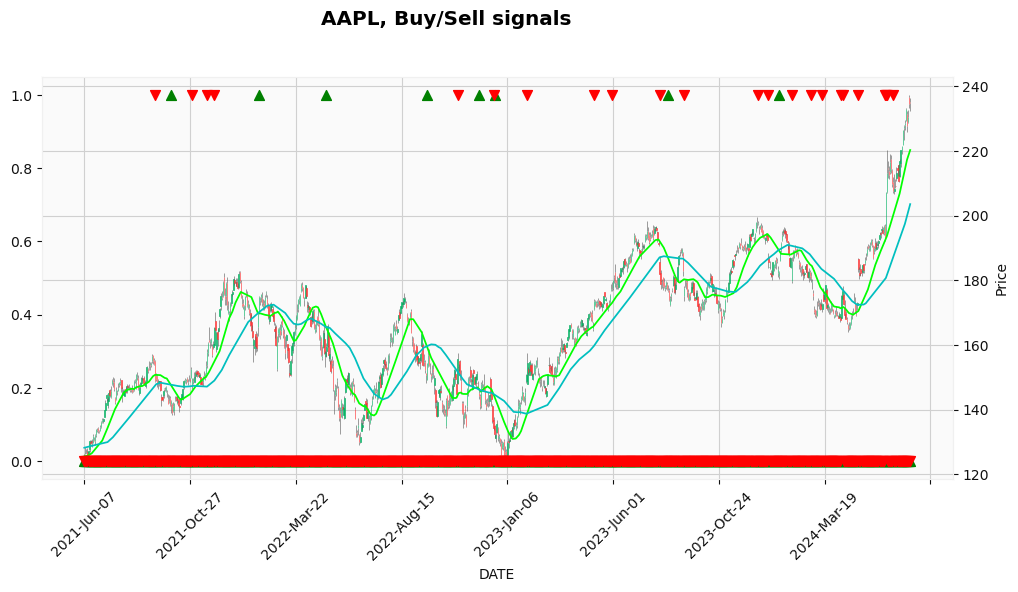

In [164]:
start_date = result.index[0]
finish_date = result.index[-1]

# make mva 20/50 days
mav20 = data['Close'].rolling(window=20).mean()
mav20 = mav20[mav20.index >= start_date]
mav20 = mav20[mav20.index <= finish_date]
mav50 = data['Close'].rolling(window=50).mean()
mav50 = mav50[mav50.index >= start_date]
mav50 = mav50[mav50.index <= finish_date]

# make additional plots
apds = [mpf.make_addplot(mav20,color='lime'),
        mpf.make_addplot(mav50,color='c'), 
        mpf.make_addplot(result['target'], type='scatter', markersize=50, marker='^', color='green'),
        mpf.make_addplot(result['pred'], type='scatter', markersize=50, marker='v', color='red'),
]

# crop data
data1 = data.loc[(data.index >= start_date) & (data.index <= finish_date)]

# make figure
fig, axs = mpf.plot(data1,

	addplot=apds,
	style='yahoo',
	type='candle',
	figratio=(22,10),
	title='AAPL, Buy/Sell signals',
	ylabel='Price',
	returnfig=True,
	
	xlabel='DATE')